In [2]:
pip install rfpimp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10667 sha256=4d185716bdead23492630e5e2c86b5b379056fb742a2de92f62cbb7080ca1498
  Stored in directory: /root/.cache/pip/wheels/d9/f2/53/6d8c73011f73fc347598d683ff8b2343605ad43474ae083816
Successfully built rfpimp


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.inspection import permutation_importance
from rfpimp import dropcol_importances, plot_importances 
from google.colab import drive

import string
import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [4]:
drive.mount('/content/drive')
url ='/content/drive/MyDrive/Datasets/train.csv'

Mounted at /content/drive


In [5]:
cols = list(pd.read_csv(url, nrows =1))
print(cols)

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [6]:
data= pd.read_csv(url, usecols=cols )

In [7]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [8]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [9]:
age_by_pclass_sex = data.groupby(['Sex', 'Pclass']).median()['Age']
data['Age'] = data.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

In [10]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [11]:
data[data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [12]:
data['Embarked'] = data['Embarked'].fillna('S')

In [13]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [14]:
data["Deck"] = data['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

In [15]:
df_all_decks = data.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

In [16]:
idx = data[data['Deck'] == 'T'].index
data.loc[idx, 'Deck'] = 'A'

In [17]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  Deck         891 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB
None


In [18]:
df_all_decks_survived = data.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

In [19]:
data['Deck'] = data['Deck'].replace(['A', 'B', 'C'], 'ABC')
data['Deck'] = data['Deck'].replace(['D', 'E'], 'DE')
data['Deck'] = data['Deck'].replace(['F', 'G'], 'FG')

data['Deck'].value_counts()

M      687
ABC    122
DE      65
FG      17
Name: Deck, dtype: int64

In [20]:
data.drop(['Cabin'], inplace=True, axis=1)

In [21]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,M
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,ABC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,M
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,ABC
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,M
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S,M
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S,ABC
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,21.5,1,2,W./C. 6607,23.4500,S,M
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,ABC


In [22]:
data['Fare'].unique()

array([  7.25  ,  71.2833,   7.925 ,  53.1   ,   8.05  ,   8.4583,
        51.8625,  21.075 ,  11.1333,  30.0708,  16.7   ,  26.55  ,
        31.275 ,   7.8542,  16.    ,  29.125 ,  13.    ,  18.    ,
         7.225 ,  26.    ,   8.0292,  35.5   ,  31.3875, 263.    ,
         7.8792,   7.8958,  27.7208, 146.5208,   7.75  ,  10.5   ,
        82.1708,  52.    ,   7.2292,  11.2417,   9.475 ,  21.    ,
        41.5792,  15.5   ,  21.6792,  17.8   ,  39.6875,   7.8   ,
        76.7292,  61.9792,  27.75  ,  46.9   ,  80.    ,  83.475 ,
        27.9   ,  15.2458,   8.1583,   8.6625,  73.5   ,  14.4542,
        56.4958,   7.65  ,  29.    ,  12.475 ,   9.    ,   9.5   ,
         7.7875,  47.1   ,  15.85  ,  34.375 ,  61.175 ,  20.575 ,
        34.6542,  63.3583,  23.    ,  77.2875,   8.6542,   7.775 ,
        24.15  ,   9.825 ,  14.4583, 247.5208,   7.1417,  22.3583,
         6.975 ,   7.05  ,  14.5   ,  15.0458,  26.2833,   9.2167,
        79.2   ,   6.75  ,  11.5   ,  36.75  ,   7.7958,  12.5

In [23]:
data['Fare'] = pd.qcut(data["Fare"], q=13, labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
data['Age'] = pd.qcut(data["Age"], q=10, labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [24]:
data['Fare']

0       1
1      11
2       3
3      10
4       3
       ..
886     5
887     9
888     7
889     9
890     1
Name: Fare, Length: 891, dtype: category
Categories (13, object): ['0' < '1' < '2' < '3' ... '9' < '10' < '11' < '12']

In [25]:
data['Age']

0      2
1      7
2      4
3      7
4      7
      ..
886    5
887    1
888    2
889    4
890    6
Name: Age, Length: 891, dtype: category
Categories (10, object): ['0' < '1' < '2' < '3' ... '6' < '7' < '8' < '9']

In [26]:
data["Family_Size"] = data['SibSp'] + data['Parch'] + 1

In [27]:
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
data['Family_Size_Grouped'] = data['Family_Size'].map(family_map)

In [28]:
data['Family_Size']

0      2
1      2
2      1
3      2
4      1
      ..
886    1
887    1
888    4
889    1
890    1
Name: Family_Size, Length: 891, dtype: int64

In [29]:
data['Ticket_Frequency'] = data.groupby('Ticket')['Ticket'].transform('count')

In [30]:
data['Title'] = data['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
data['Is_Married'] = 0
data['Is_Married'].loc[data['Title'] == 'Mrs'] = 1

In [31]:
data['Title'] = data['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
data['Title'] = data['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

In [32]:
drop_cols = ['Ticket', 'Name'  ]
data.drop(columns=drop_cols, inplace=True)

In [33]:
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Family_Size,Family_Size_Grouped,Ticket_Frequency,Title,Is_Married
0,1,0,3,male,2,1,0,1,S,M,2,Small,1,Mr,0
1,2,1,1,female,7,1,0,11,C,ABC,2,Small,1,Miss/Mrs/Ms,1
2,3,1,3,female,4,0,0,3,S,M,1,Alone,1,Miss/Mrs/Ms,0
3,4,1,1,female,7,1,0,10,S,ABC,2,Small,2,Miss/Mrs/Ms,1
4,5,0,3,male,7,0,0,3,S,M,1,Alone,1,Mr,0


In [34]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped']

for feature in non_numeric_features:        
    data[feature] = LabelEncoder().fit_transform(data[feature])

In [35]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for feature in cat_features:
      encoded_feat = OneHotEncoder().fit_transform(data[feature].values.reshape(-1, 1)).toarray()
      n = data[feature].nunique()
      cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
      encoded_data = pd.DataFrame(encoded_feat, columns=cols)
      encoded_data.index = data.index
      encoded_features.append(encoded_data)

data = pd.concat([data, *encoded_features[:6]], axis=1)

In [36]:
print(data)

     PassengerId  Survived  Pclass  Sex Age  SibSp  Parch Fare  Embarked  \
0              1         0       3    1   2      1      0    1         2   
1              2         1       1    0   7      1      0   11         0   
2              3         1       3    0   4      0      0    3         2   
3              4         1       1    0   7      1      0   10         2   
4              5         0       3    1   7      0      0    3         2   
..           ...       ...     ...  ...  ..    ...    ...  ...       ...   
886          887         0       2    1   5      0      0    5         2   
887          888         1       1    0   1      0      0    9         2   
888          889         0       3    0   2      1      2    7         2   
889          890         1       1    1   4      0      0    9         0   
890          891         0       3    1   6      0      0    1         1   

     Deck  ...  Embarked_2  Embarked_3  Title_1  Title_2  Title_3  Title_4  \
0       3

In [37]:
data.count(axis=0)

PassengerId              891
Survived                 891
Pclass                   891
Sex                      891
Age                      891
SibSp                    891
Parch                    891
Fare                     891
Embarked                 891
Deck                     891
Family_Size              891
Family_Size_Grouped      891
Ticket_Frequency         891
Title                    891
Is_Married               891
Pclass_1                 891
Pclass_2                 891
Pclass_3                 891
Sex_1                    891
Sex_2                    891
Deck_1                   891
Deck_2                   891
Deck_3                   891
Deck_4                   891
Embarked_1               891
Embarked_2               891
Embarked_3               891
Title_1                  891
Title_2                  891
Title_3                  891
Title_4                  891
Family_Size_Grouped_1    891
Family_Size_Grouped_2    891
Family_Size_Grouped_3    891
Family_Size_Gr

In [38]:
drop_cols = ['Deck', 'Embarked', 'Family_Size', 'Family_Size_Grouped',
             'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Title']

data.drop(columns=drop_cols, inplace=True)
data.head()

,Survived,Age,Fare,Ticket_Frequency,Is_Married,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,...,Embarked_2,Embarked_3,Title_1,Title_2,Title_3,Title_4,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3,Family_Size_Grouped_4
0,0,2,1,1,0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1,7,11,1,1,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1,4,3,1,0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1,7,10,2,1,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0,7,3,1,0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [39]:
X = data.drop(('Survived'), axis=1)
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 11 )


print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

feature_names = X_train.columns

X_train shape: (623, 24)
y_train shape: (623,)
X_test shape: (268, 24)
y_test shape: (268,)


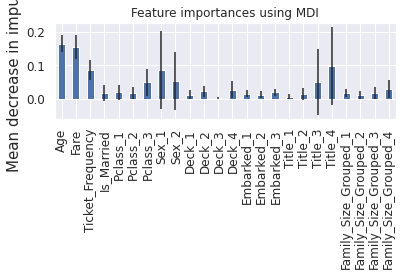

In [40]:
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)


import pandas as pd
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.tick_params(axis= 'x', labelsize = 12)
ax.tick_params(axis= 'y', labelsize = 12)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity", size = 15)
fig.tight_layout()

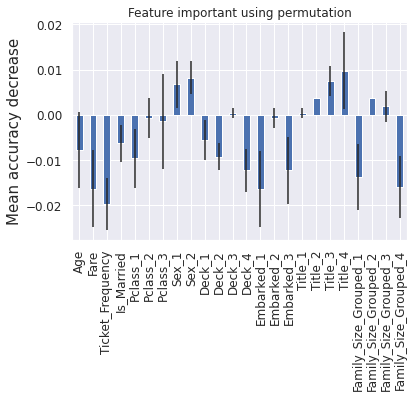

In [44]:
result = permutation_importance(forest, X_test, y_test, n_repeats = 10, random_state= 42, n_jobs = 2)

forest_importances = pd.Series(result.importances_mean, index = feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.tick_params(axis= 'x', labelsize = 12)
ax.tick_params(axis= 'y', labelsize = 12)
ax.set_title("Feature important using permutation")
ax.set_ylabel("Mean accuracy decrease", size = 15)
fig.tight_layout
plt.show()

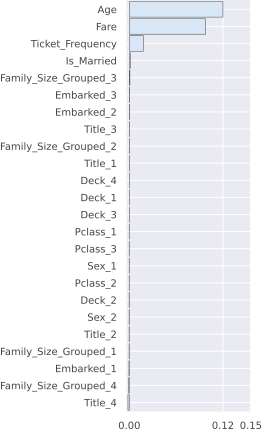

In [45]:
rf = RandomForestRegressor(n_estimators = 100, n_jobs=-1)
rf.fit(X_train, y_train)
result = dropcol_importances(rf, X_train, y_train)
viz = plot_importances(result, vscale= 1.2)
viz

In [46]:
print(result)

                       Importance
Feature                          
Age                      0.115550
Fare                     0.094170
Ticket_Frequency         0.017395
Is_Married               0.001273
Family_Size_Grouped_3    0.000731
Embarked_3               0.000288
Embarked_2               0.000224
Title_3                  0.000153
Family_Size_Grouped_2    0.000146
Title_1                  0.000138
Deck_4                   0.000070
Deck_1                  -0.000082
Deck_3                  -0.000095
Pclass_1                -0.000152
Pclass_3                -0.000163
Sex_1                   -0.000173
Pclass_2                -0.000177
Deck_2                  -0.000242
Sex_2                   -0.000251
Title_2                 -0.000259
Family_Size_Grouped_1   -0.000275
Embarked_1              -0.000462
Family_Size_Grouped_4   -0.000867
Title_4                 -0.001663
